# L'Oreal Skincare Optimizer - Multi-label Classification

**Objective**: Skin type and condition prediction using ensemble methods.

**Key Features**:
- TF-IDF with trigrams (1800 features)
- XGBoost with ClassifierChain
- Frequency-optimized label ordering
- Threshold optimization on validation set

In [1]:
!pip install scikit-learn==1.8.0 --upgrade

In [2]:
!pip install codecarbon

In [3]:
import re
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import f1_score, hamming_loss, confusion_matrix
from xgboost import XGBClassifier
from scipy.sparse import hstack
from codecarbon import EmissionsTracker
from sklearn.preprocessing import StandardScaler
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

np.random.seed(42)
os.makedirs("csv", exist_ok=True)
os.makedirs("reports", exist_ok=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)
pd.set_option('display.max_colwidth', None)

import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

Device: cuda


In [4]:
df = pd.read_excel("/content/dataset.xlsx")
df.drop_duplicates(subset=["text_raw"], inplace=True)

def extract_and_remove_sizes(text):
    if not isinstance(text, str):
        return text, ""
    text_lower = text.lower()
    extracted = []
    patterns = [
        (r"\\d+(?:\\.\\d+)?\\s*(?:ml|milliliter)", "ml"),
        (r"\\d+(?:\\.\\d+)?\\s*(?:g|gram)", "g"),
        (r"\\d+(?:\\.\\d+)?\\s*(?:fl\\.?\\s*oz\\.?)", "fl oz"),
    ]
    found_ml = found_g = None
    for pattern, unit in patterns:
        for match in re.finditer(pattern, text_lower):
            if unit == "ml" and not found_ml:
                extracted.append(match.group())
                found_ml = True
            elif unit == "g" and not found_ml and not found_g:
                extracted.append(match.group())
                found_g = True
    text_clean = text
    for p in [r"\\d+(?:\\.\\d+)?\\s*(?:ml|g|oz)", r"\\(\\d+\\s*(?:ml|g|oz)\\)"]:
        text_clean = re.sub(p, " ", text_clean, flags=re.IGNORECASE)
    return re.sub(r"\\s+", " ", text_clean).strip(), "; ".join(extracted)

def clean_text(t):
    if not isinstance(t, str):
        return ""
    t = unicodedata.normalize("NFKD", t)
    t = "".join(c for c in t if not unicodedata.combining(c))
    t = re.sub(r'\\bvit\\.?\\s*c\\b', 'vitamin c', t, flags=re.IGNORECASE)
    t = re.sub(r'\\bvit\\.?\\s*e\\b', 'vitamin e', t, flags=re.IGNORECASE)
    t = re.sub(r'\\baha\\b', 'alpha hydroxy acid', t, flags=re.IGNORECASE)
    t = re.sub(r'\\bbha\\b', 'beta hydroxy acid', t, flags=re.IGNORECASE)
    t = re.sub(r'\\bretinol\\s*a\\b', 'retinol', t, flags=re.IGNORECASE)
    t = t.replace('spf', 'sun protection factor')
    t = t.lower()
    t = re.sub(r"<[^>]+>", " ", t)
    t = re.sub(r"([a-z])([A-Z])", r"\\1 \\2", t)
    t = re.sub(r'\\b\\d+(?:\\.\\d+)?\\s*(?:ml|oz|g|mg|fl)\\b', ' ', t)
    t = re.sub(r'\\b(bottle|jar|pack|shipping|weight|piece|items|count)\\b', ' ', t)
    t = re.sub(r"[^a-z0-9\\s\\-]", " ", t)
    t = re.sub(r"\\s+", " ", t).strip()
    seen = set()
    return " ".join(w for w in t.split() if w not in seen and not seen.add(w))

def extract_sizes_series(text):
    return pd.Series(extract_and_remove_sizes(text))

def finalize_text(text):
    if not isinstance(text, str):
        return ""
    seen = set()
    return " ".join(w for w in text.split() if w not in seen and not seen.add(w))

df[["text_clean", "extracted_sizes"]] = df["text_raw"].apply(extract_sizes_series)
df["text_clean"] = df["text_clean"].apply(clean_text)

In [5]:
df["fine_wrinkles"] = df[["fine_lines", "wrinkles_fine-lines"]].max(axis=1).astype(int)

TARGET_CONDITIONS = [
    "dry", "normal", "oily", "combination",
    "acne", "pores", "fine_wrinkles", "lack_radiance", "lack_firmness", "dark_pigmentation",
    "sensitivity-high"
]

df_filtered = df[df[TARGET_CONDITIONS].sum(axis=1) > 0].copy()
df_filtered["final_text"] = df_filtered["text_clean"].apply(finalize_text)

print(f"Samples: {len(df_filtered)}")
print(f"Targets: {len(TARGET_CONDITIONS)}")

Samples: 4136
Targets: 11


In [6]:
feature_defs = {
    "has_vitamin_c": ["vitamin c", "ascorbic", "citrus"],
    "has_retinol": ["retinol", "retinal", "vitamin a", "tretinoin"],
    "has_niacinamide": ["niacinamide", "b3"],
    "has_hyaluronic": ["hyaluronic", "sodium hyaluronate", "ha"],
    "has_salicylic": ["salicylic", "bha", "willow bark"],
    "has_glycolic": ["glycolic", "aha", "alpha hydroxy acid"],
    "has_peptide": ["peptide", "ceramide", "collagen"],
    "has_ferulic": ["ferulic"],
    "has_clay": ["clay", "kaolin", "charcoal"],
    "has_spf": ["spf", "sunscreen", "sun", "uv", "broad spectrum", "sun protection factor"],
    "has_hydrating": ["hydrating", "moisture", "moisturizing"],
    "has_oil_control": ["oil free", "matte", "non comedogenic", "water-based"],
    "has_sensitive": ["sensitive", "gentle", "soothe"],
    "has_anti_aging": ["anti aging", "wrinkle", "firm", "collagen"],
    "has_acne": ["acne", "blemish", "pore"],
    "has_radiance": ["bright", "glow", "radiance"],
    "is_serum": ["serum"],
    "is_cream": ["cream", "balm"],
    "is_cleanser": ["cleanser", "wash"],
    "is_toner": ["toner"],
    "is_mask": ["mask"],
    "is_sunscreen": ["sunscreen", "spf"],
    "is_moisturizer": ["moisturizer", "lotion"],
    "is_day": ["day", "morning"],
    "is_night": ["night"],
    "is_daily": ["daily"],
}

def check_keywords_in_text(text, keywords):
    if not isinstance(text, str):
        return 0
    text_lower = text.lower()
    for kw in keywords:
        if kw in text_lower:
            return 1
    return 0

for name, kws in feature_defs.items():
    df_filtered[name] = df_filtered["text_clean"].apply(check_keywords_in_text, keywords=kws)

df_filtered["sensitivity_high_text"] = df_filtered["text_clean"].apply(
    lambda t: 1 if isinstance(t, str) and any(w in t.lower() for w in ["sensitive", "gentle", "soothe"]) else 0)
df_filtered["sensitivity_low_text"] = df_filtered["text_clean"].apply(
    lambda t: 1 if isinstance(t, str) and "resistant" in t.lower() else 0)
df_filtered["text_length"] = df_filtered["text_clean"].str.len()
df_filtered["word_count"] = df_filtered["text_clean"].str.split().str.len()
df_filtered["total_actives"] = df_filtered[[c for c in feature_defs if c.startswith("has_")]].sum(axis=1)
df_filtered["total_concerns"] = df_filtered[["has_hydrating", "has_oil_control", "has_sensitive",
                                             "has_anti_aging", "has_acne", "has_radiance"]].sum(axis=1)
df_filtered["product_complexity"] = df_filtered[[c for c in feature_defs if c.startswith("is_")]].sum(axis=1)

feature_cols = (
    list(feature_defs.keys()) +
    ["text_length", "word_count", "total_actives", "total_concerns", "product_complexity"] +
    ["sensitivity_high_text", "sensitivity_low_text"]
)

print(f"Engineered features: {len(feature_cols)}")

Engineered features: 33


In [7]:
train_idx, temp_idx = train_test_split(
    np.arange(len(df_filtered)), test_size=0.2, random_state=42,
    stratify=df_filtered[TARGET_CONDITIONS].sum(axis=1).values
)

temp_df = df_filtered.iloc[temp_idx]
val_idx_local, test_idx_local = train_test_split(
    np.arange(len(temp_df)), test_size=0.5, random_state=42
)

val_idx = temp_idx[val_idx_local]
test_idx = temp_idx[test_idx_local]

df_train = df_filtered.iloc[train_idx].copy()
df_val = df_filtered.iloc[val_idx].copy()
df_test = df_filtered.iloc[test_idx].copy()

X_train_raw = df_train["final_text"]
X_val_raw = df_val["final_text"]
X_test_raw = df_test["final_text"]
y_train = df_train[TARGET_CONDITIONS]
y_val = df_val[TARGET_CONDITIONS]
y_test = df_test[TARGET_CONDITIONS]

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

Train: 3308, Val: 414, Test: 414


In [8]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    if not isinstance(text, str):
        return ""
    try:
        tokens = word_tokenize(text.lower())
        return " ".join([lemmatizer.lemmatize(t) for t in tokens])
    except:
        return text

X_train_lemm = X_train_raw.apply(lemmatize_text)
X_val_lemm = X_val_raw.apply(lemmatize_text)
X_test_lemm = X_test_raw.apply(lemmatize_text)

COSMETIC_STOP_WORDS = [
    "skin", "face", "product", "formula", "beauty", "care",
    "treatment", "helps", "designed", "perfect", "ideal",
    "looking", "offer", "provide", "give", "make", "use"
]

def tokenize_split(text):
    return text.split()

tfidf = TfidfVectorizer(
    max_features=1800,
    ngram_range=(1, 3),
    stop_words=list(set(["english"] + COSMETIC_STOP_WORDS)),
    min_df=2,
    max_df=0.7,
    tokenizer=tokenize_split,
    sublinear_tf=True
)

X_train_tf = tfidf.fit_transform(X_train_lemm)
X_val_tf = tfidf.transform(X_val_lemm)
X_test_tf = tfidf.transform(X_test_lemm)

print(f"TF-IDF features: {X_train_tf.shape[1]}")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:526: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF features: 1800


In [9]:
scaler = StandardScaler()
X_train_eng = scaler.fit_transform(df_train[feature_cols].fillna(0))
X_val_eng = scaler.transform(df_val[feature_cols].fillna(0))
X_test_eng = scaler.transform(df_test[feature_cols].fillna(0))

X_train = hstack([X_train_tf, X_train_eng])
X_val = hstack([X_val_tf, X_val_eng])
X_test = hstack([X_test_tf, X_test_eng])

print(f"Total features: {X_train.shape[1]}")

Total features: 1833


In [10]:
CHAIN_ORDER_NAMES = [
    "fine_wrinkles", "lack_radiance", "acne", "pores",
    "dry", "normal", "oily", "combination",
    "lack_firmness", "dark_pigmentation", "sensitivity-high"
]

CHAIN_ORDER = [TARGET_CONDITIONS.index(name) for name in CHAIN_ORDER_NAMES]
print(f"Chain order: {CHAIN_ORDER_NAMES}")

Chain order: ['fine_wrinkles', 'lack_radiance', 'acne', 'pores', 'dry', 'normal', 'oily', 'combination', 'lack_firmness', 'dark_pigmentation', 'sensitivity-high']


In [11]:
base_xgb = XGBClassifier(
    tree_method='hist',
    device='cuda',
    n_estimators=1500,
    learning_rate=0.008,
    max_depth=9,
    subsample=0.75,
    colsample_bytree=0.65,
    reg_alpha=0.05,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

tracker = EmissionsTracker(output_dir="reports", output_file="emissions.csv", log_level="error")
tracker.start()

model = ClassifierChain(base_xgb, order=CHAIN_ORDER)
model.fit(X_train, y_train)

emissions = tracker.stop()

print(f"Emissions: {emissions:.4f} g CO2")

[codecarbon WARNING @ 13:04:53] Multiple instances of codecarbon are allowed to run at the same time.


Emissions: 0.0009 g CO2


In [12]:
y_proba_val = model.predict_proba(X_val)
y_proba_test = model.predict_proba(X_test)

# STEP 1: Per-label threshold optimization (individual F1)
print("=== STEP 1: Per-label threshold optimization ===")
individual_thresh = []
for i in range(len(TARGET_CONDITIONS)):
    probas = y_proba_val[:, i]
    prob_min, prob_max = probas.min(), probas.max()
    prob_mean = probas.mean()
    prob_q25, prob_q75 = np.percentile(probas, [25, 75])

    # Define search range based on distribution, BUT constrained to [0.25, 0.75]
    t_min = max(0.25, prob_q25 - 0.1)   # Minimum 0.25
    t_max = min(0.75, max(prob_q75 + 0.1, 0.5))   # Maximum 0.75

    best_f1, best_t = 0, 0.5
    for t in np.linspace(t_min, t_max, 150):  # MORE: 150 thresholds instead of 60
        preds = (y_proba_val[:, i] > t).astype(int)
        score = f1_score(y_val.iloc[:, i], preds, zero_division=0)
        if score > best_f1:
            best_f1, best_t = score, t

    individual_thresh.append(best_t)
    print(f"{TARGET_CONDITIONS[i]:20s}: thresh={best_t:.3f}, F1={best_f1:.4f}")

# Calculate F1 micro with individual thresholds
y_pred_individual = np.zeros_like(y_proba_val)
for i in range(len(TARGET_CONDITIONS)):
    y_pred_individual[:, i] = (y_proba_val[:, i] > individual_thresh[i]).astype(int)
f1_micro_individual = f1_score(y_val, y_pred_individual, average='micro')
print(f"\\nF1 Micro with individual thresholds: {f1_micro_individual:.4f}")

# STEP 2: Global optimization for F1 Micro
print("\\n=== STEP 2: Global threshold optimization for F1 Micro ===")

# Start from individual thresholds and fine-tune around them
optimized_thresh = individual_thresh.copy()
best_f1_micro = f1_micro_individual
improved = True
iteration = 0

while improved and iteration < 100:  # MORE: 100 iterations instead of 20
    improved = False
    iteration += 1

    # Try adjusting each threshold
    for i in range(len(TARGET_CONDITIONS)):
        current_t = optimized_thresh[i]
        best_t_for_label = current_t

        # Test values around current threshold (±0.08), constrained to [0.25, 0.75]
        for delta in np.linspace(-0.08, 0.08, 21):  # MORE: 21 steps instead of 11, range ±0.08
            test_t = max(0.25, min(0.75, current_t + delta))  # Constrained to [0.25, 0.75]

            # Apply test threshold for this label
            temp_thresh = optimized_thresh.copy()
            temp_thresh[i] = test_t

            # Calculate predictions and F1 micro
            y_pred_temp = np.zeros_like(y_proba_val)
            for j in range(len(TARGET_CONDITIONS)):
                y_pred_temp[:, j] = (y_proba_val[:, j] > temp_thresh[j]).astype(int)

            f1_temp = f1_score(y_val, y_pred_temp, average='micro', zero_division=0)

            if f1_temp > best_f1_micro + 0.0001:  # Small epsilon to avoid noise
                best_f1_micro = f1_temp
                best_t_for_label = test_t
                improved = True

        # Update if improvement found
        if best_t_for_label != current_t:
            print(f"Iter {iteration}: {TARGET_CONDITIONS[i]:20s}: {current_t:.3f} -> {best_t_for_label:.3f} (F1={best_f1_micro:.4f})")
            optimized_thresh[i] = best_t_for_label

print(f"\\n=== FINAL RESULTS ===")
print(f"F1 Micro before: {f1_micro_individual:.4f}")
print(f"F1 Micro after:  {best_f1_micro:.4f}")
print(f"Improvement:     {(best_f1_micro - f1_micro_individual) * 100:.2f}%")

print("\\nFinal thresholds:")
for label, t_ind, t_opt in zip(TARGET_CONDITIONS, individual_thresh, optimized_thresh):
    change = " (same)" if abs(t_ind - t_opt) < 0.001 else f" ({t_ind:.3f} -> {t_opt:.3f})"
    print(f"  {label:20s}: {t_opt:.3f}{change}")

=== STEP 1: Per-label threshold optimization ===
dry                 : thresh=0.334, F1=0.6016
normal              : thresh=0.250, F1=0.5210
oily                : thresh=0.389, F1=0.6747
combination         : thresh=0.250, F1=0.4198
acne                : thresh=0.435, F1=0.8046
pores               : thresh=0.441, F1=0.7547
fine_wrinkles       : thresh=0.324, F1=0.8777
lack_radiance       : thresh=0.300, F1=0.7748
lack_firmness       : thresh=0.433, F1=0.7089
dark_pigmentation   : thresh=0.255, F1=0.7037
sensitivity-high    : thresh=0.471, F1=0.7714
\nF1 Micro with individual thresholds: 0.7302
\n=== STEP 2: Global threshold optimization for F1 Micro ===
Iter 1: combination         : 0.250 -> 0.290 (F1=0.7308)
Iter 1: fine_wrinkles       : 0.324 -> 0.252 (F1=0.7310)
\n=== FINAL RESULTS ===
F1 Micro before: 0.7302
F1 Micro after:  0.7310
Improvement:     0.08%
\nFinal thresholds:
  dry                 : 0.334 (same)
  normal              : 0.250 (same)
  oily                : 0.389 (same

In [13]:
y_pred_final = np.zeros_like(y_proba_test)
for i in range(len(TARGET_CONDITIONS)):
    y_pred_final[:, i] = (y_proba_test[:, i] > optimized_thresh[i]).astype(int)

y_pred_final_df = pd.DataFrame(y_pred_final, index=y_test.index, columns=TARGET_CONDITIONS)
y_proba_test_df = pd.DataFrame(y_proba_test, index=y_test.index, columns=TARGET_CONDITIONS)

f1_micro = f1_score(y_test, y_pred_final, average='micro')
f1_macro = f1_score(y_test, y_pred_final, average='macro')
hamming = hamming_loss(y_test, y_pred_final)
per_label_f1 = f1_score(y_test, y_pred_final, average=None, zero_division=0)

print(f"F1 Micro:  {f1_micro:.4f}")
print(f"F1 Macro:  {f1_macro:.4f}")
print(f"Hamming:   {hamming:.4f}")
print(f"Energy:    {emissions:.4f} g CO2")
print("")
print("Per-Label F1:")
for label, score in zip(TARGET_CONDITIONS, per_label_f1):
    print(f"  {label:20s}: {score:.4f}")

F1 Micro:  0.7249
F1 Macro:  0.6865
Hamming:   0.1036
Energy:    0.0009 g CO2

Per-Label F1:
  dry                 : 0.7416
  normal              : 0.5970
  oily                : 0.6977
  combination         : 0.4222
  acne                : 0.7692
  pores               : 0.8145
  fine_wrinkles       : 0.8551
  lack_radiance       : 0.6990
  lack_firmness       : 0.6815
  dark_pigmentation   : 0.7429
  sensitivity-high    : 0.5312


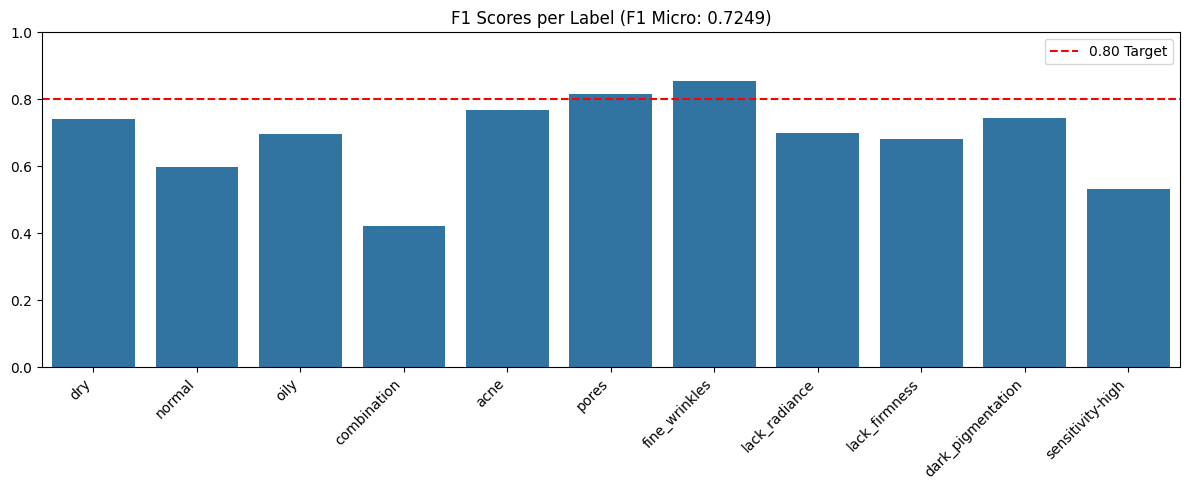

                Label   TP   TN  FP  FN  Precision  Recall      F1
0                 dry   66  302  23  23     0.7416  0.7416  0.7416
1              normal   40  320  33  21     0.5479  0.6557  0.5970
2                oily   30  358  12  14     0.7143  0.6818  0.6977
3         combination   19  343  13  39     0.5938  0.3276  0.4222
4                acne   85  278  18  33     0.8252  0.7203  0.7692
5               pores   90  283  12  29     0.8824  0.7563  0.8145
6       fine_wrinkles  118  256  24  16     0.8310  0.8806  0.8551
7       lack_radiance   72  280  30  32     0.7059  0.6923  0.6990
8       lack_firmness   46  325  18  25     0.7188  0.6479  0.6815
9   dark_pigmentation   39  348  12  15     0.7647  0.7222  0.7429
10   sensitivity-high   17  367   8  22     0.6800  0.4359  0.5312


In [14]:
plt.figure(figsize=(12, 5))
sns.barplot(x=TARGET_CONDITIONS, y=per_label_f1)
plt.title(f"F1 Scores per Label (F1 Micro: {f1_micro:.4f})")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.axhline(y=0.8, color='red', linestyle='--', label='0.80 Target')
plt.legend()
plt.tight_layout()
plt.savefig("reports/f1_scores.png", dpi=150)
plt.show()

confusion_data = []
for idx, label in enumerate(TARGET_CONDITIONS):
    yt = y_test.iloc[:, idx].values
    yp = y_pred_final[:, idx]
    tn, fp, fn, tp = confusion_matrix(yt, yp).ravel()
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    confusion_data.append({
        "Label": label, "TP": int(tp), "TN": int(tn), "FP": int(fp), "FN": int(fn),
        "Precision": round(prec, 4), "Recall": round(rec, 4), "F1": round(f1, 4)
    })

confusion_df = pd.DataFrame(confusion_data)
print(confusion_df)
confusion_df.to_csv("csv/confusion_metrics.csv", index=False)

In [15]:
tfidf_features = {
    "feature_names": tfidf.get_feature_names_out(),
    "vocabulary": tfidf.vocabulary_,
    "idf": tfidf.idf_
}

metrics = {
    'version': 'V36',
    'features': X_train.shape[1],
    'f1_micro': f1_micro,
    'f1_macro': f1_macro,
    'hamming': hamming
}

joblib.dump(
    {
        "model": model,
        "vectorizer": tfidf,
        "scaler": scaler,
        "X_test": X_test,
        "y_test": y_test,
        "y_proba": y_proba_test_df,
        "y_pred": y_pred_final_df,
        "TARGET_COLS": TARGET_CONDITIONS,
        "CHAIN_ORDER": CHAIN_ORDER_NAMES,
        "tfidf_features": tfidf_features,
        "df_test": df_test,
        "feature_cols": feature_cols,
        "optimized_thresh": optimized_thresh,
        "f1_micro": f1_micro,
        "f1_macro": f1_macro,
        "hamming": hamming,
        "emissions": emissions,
        "metrics": metrics
    },
    "deployment_pack.pkl",
    compress=9
)

model_size_mb = os.path.getsize("deployment_pack.pkl") / (1024 * 1024)
print(f"Model saved: {model_size_mb:.2f} MB")

Model saved: 15.82 MB


In [16]:
with open("reports/report.txt", "w", encoding="utf-8") as f:
    f.write("L'OREAL SKINCARE OPTIMIZER\n\n")
    f.write(f"Targets: {len(TARGET_CONDITIONS)}\n")
    f.write(f"Chain Order: {CHAIN_ORDER_NAMES}\n\n")
    f.write(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}\n")
    f.write(f"Features: {X_train.shape[1]} (1800 TF-IDF + {len(feature_cols)} engineered)\n\n")
    f.write(f"F1 Micro:  {f1_micro:.4f}\n")
    f.write(f"F1 Macro:  {f1_macro:.4f}\n")
    f.write(f"Hamming:   {hamming:.4f}\n")
    f.write(f"Energy:    {emissions:.4f} g CO2\n")
    f.write(f"Model Size: {model_size_mb:.2f} MB\n")

print("Report saved")

Report saved
